[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yokolet/DeepLearning/blob/master/DCGAN_by_PyTorch.ipynb)

# DCGAN by PyTorch

This is a Deep Convolutional Generative Adversarial Networks(DCGAN) using Street View House Numbers Dataset(SVHN).

The code is originally Udacity's Deep Learning tutorial, [dcgan-svhn](https://github.com/udacity/deep-learning/tree/master/dcgan-svhn). It is wriiten by TensorFlow. Recently, another major machine learning library, [PyTorch](https://pytorch.org/) drew people's attention. I'm among them. Out of my curiosity, I tried the same DCGAN by PyTorch. For this attempt, some parts of code were taken from PyTorch's [dcgan example](https://github.com/pytorch/examples/blob/master/dcgan/main.py).

The model is created following the [Original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf). The dataset is [the Street View House Numbers Dataset (SVHN)](http://ufldl.stanford.edu/housenumbers/), whose size is 32 x 32.

The notebook works on Google's colaboratory environment with setting of GPU for its runtime. The code includes PyTorch installation since PyTorch is not preinstalled on colaboratory at this moment.

## PyTorch Installation and import

For the first time importing torch without install PyTorch, the colaboratory provides the code to install PyTorch. The code is set up to look at a specific website. This works, but simply calling pip install works as well.

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip3 install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59cca000 @  0x7f26d2db12a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 20.4MB/s 
    100% |████████████████████████████████| 2.0MB 4.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Other libraries

To show SVHN images, the cell below imports three libraries.

In [0]:
%matplotlib  inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

## Parameters

Below is definitions of various parameters.

In [3]:
dataroot = './data'    # path to dataset
batchSize = 128        # input batch size
workers = 2            # number of data loading workers
nz = 100               # size of a noise vector z
ngf = 64               # generator factor
ndf = 64               # discriminator factor
nc = 3                 # number of color channels
lr = 0.0002            # learning rate
alpha = 0.2            # leaky ReLU parameter
beta1 = 0.5            # Adam Optimizer parameter
niter = 25             # number of epochs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Getting the dataset

The cell below downloads the SVHN dataset using torchvision. Also, dataloader are created using PyTorch's DataLoader.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.SVHN(root=dataroot, split='train',
                                     transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ]),
                                     download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=workers)
testset = torchvision.datasets.SVHN(root=dataroot, split='test',
                                    transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ]),
                                    download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=workers)

## Sample images

The SVHN files are .mat files typically used with Matlab. Those are loaded using scipy.io.loadmat which is imported above. Each image is 32 x 32 with 3 color channels (RGB). These are the real images to be passed to the discriminator. The generator is expected to create the same image eventually.

In [0]:
trainset = loadmat(dataroot + '/train_32x32.mat')
testset = loadmat(dataroot + '/test_32x32.mat')

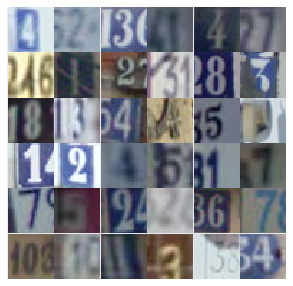

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

## Generator

The input will be a noise vector z. The output will be a 𝑡𝑎𝑛ℎ output with size of 32x32 which is the size of the SVHN images.

The generator will have convolutional layers to create new images. The first layer creates a deep and narrow layer, something like 4x4x512 as in the original DCGAN paper. In the layer, a batch normalization and a leaky ReLU activation will be used. following transposed convolution layers halve the depth and double the width and height of the previous layer. Again, the batch normalization and leaky ReLU come here.

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
      # input is Z, going into a convolution
      nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(ngf * 8),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ngf*8) x 4 x 4
      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 4),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ngf*4) x 8 x 8
      nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 2),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ngf*2) x 16 x 16
      nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
      nn.Tanh()
      # state size. (nc) x 32 x 32
    )

  def forward(self, input):
    output = self.main(input)
    return output

## Discriminator

The discriminator is basically a convolutional classifier. The inputs to the discriminator are 32x32x3 tensors/images. The discriminator will have a few convolutional layers, then a fully connected layer for the output. At the last layer, an activation is sigmoid. 

> In the original DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
      # input is (nc) x 32 x 32
      nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ndf) x 16 x 16
      nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ndf*2) x 8 x 8
      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ndf*4) x 4 x 4
      nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    output = self.main(input)
    return output.view(-1, 1).squeeze(1)

## Initializes models, defines a loss function and optimizers

Here, the generator and discriminator models are initialized with weights. The loss function is BCELoss, which is Binary Cross Entropy. The BCELoss is a counterpart of TensorFlow's sigmoid_cross_entropy_with_logits. The optimizer is Adam Optimizer.

In [9]:
# custom weights initialization called on models
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

g_model = Generator().to(device)
g_model.apply(weights_init)
print(g_model)

d_model = Discriminator().to(device)
d_model.apply(weights_init)
print(d_model)

# loss function
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
sample_noise = torch.randn(72, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
d_train_optim = optim.Adam(d_model.parameters(), lr=lr, betas=(beta1, 0.999))
g_train_optim = optim.Adam(g_model.parameters(), lr=lr, betas=(beta1, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope

## Showing samples

The cell below defines a function to show samples. The function is called during the training and after the training.

In [0]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
  fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                           sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = np.rollaxis(img, 0, 3)
    ax.axis('off')
    img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
    ax.set_adjustable('box-forced')
    im = ax.imshow(img, aspect='equal')

  plt.subplots_adjust(wspace=0, hspace=0)
  return fig, axes

## Training

[0/25][0/573] Loss_D: 1.7614 Loss_G: 1.4815 D(x): 0.3435 D(G(z)): 0.3436 / 0.2537


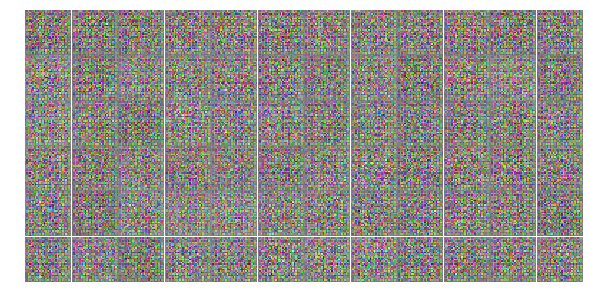

[0/25][10/573] Loss_D: 1.1651 Loss_G: 3.7945 D(x): 0.6169 D(G(z)): 0.4235 / 0.0272
[0/25][20/573] Loss_D: 0.5996 Loss_G: 4.5968 D(x): 0.7708 D(G(z)): 0.2542 / 0.0125
[0/25][30/573] Loss_D: 0.3073 Loss_G: 4.6883 D(x): 0.8671 D(G(z)): 0.1358 / 0.0114
[0/25][40/573] Loss_D: 0.1831 Loss_G: 5.3721 D(x): 0.9410 D(G(z)): 0.1120 / 0.0056
[0/25][50/573] Loss_D: 0.1229 Loss_G: 5.5421 D(x): 0.9569 D(G(z)): 0.0735 / 0.0050
[0/25][60/573] Loss_D: 0.1182 Loss_G: 5.3637 D(x): 0.9572 D(G(z)): 0.0696 / 0.0059
[0/25][70/573] Loss_D: 0.1888 Loss_G: 4.9429 D(x): 0.9219 D(G(z)): 0.0943 / 0.0088
[0/25][80/573] Loss_D: 0.6924 Loss_G: 5.6408 D(x): 0.8484 D(G(z)): 0.3647 / 0.0057
[0/25][90/573] Loss_D: 0.7892 Loss_G: 2.8051 D(x): 0.7062 D(G(z)): 0.2726 / 0.0800
[0/25][100/573] Loss_D: 0.5287 Loss_G: 2.9222 D(x): 0.8217 D(G(z)): 0.2281 / 0.0642
[0/25][110/573] Loss_D: 0.4466 Loss_G: 2.6576 D(x): 0.7850 D(G(z)): 0.1380 / 0.0786
[0/25][120/573] Loss_D: 0.9463 Loss_G: 1.5493 D(x): 0.5978 D(G(z)): 0.1003 / 0.2730
[

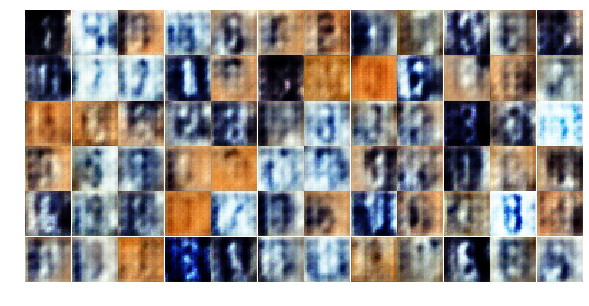

[1/25][10/573] Loss_D: 1.4928 Loss_G: 3.9938 D(x): 0.8285 D(G(z)): 0.6622 / 0.0253
[1/25][20/573] Loss_D: 0.8298 Loss_G: 2.8510 D(x): 0.8011 D(G(z)): 0.4213 / 0.0767
[1/25][30/573] Loss_D: 1.0044 Loss_G: 2.2581 D(x): 0.6529 D(G(z)): 0.3594 / 0.1509
[1/25][40/573] Loss_D: 0.4551 Loss_G: 2.8560 D(x): 0.7877 D(G(z)): 0.1465 / 0.0746
[1/25][50/573] Loss_D: 0.6216 Loss_G: 3.0177 D(x): 0.8174 D(G(z)): 0.3140 / 0.0615
[1/25][60/573] Loss_D: 0.7082 Loss_G: 2.8091 D(x): 0.7946 D(G(z)): 0.3353 / 0.0883
[1/25][70/573] Loss_D: 0.6853 Loss_G: 2.6635 D(x): 0.7513 D(G(z)): 0.2784 / 0.0892
[1/25][80/573] Loss_D: 0.5606 Loss_G: 2.1749 D(x): 0.7878 D(G(z)): 0.2450 / 0.1434
[1/25][90/573] Loss_D: 0.5570 Loss_G: 2.2938 D(x): 0.7931 D(G(z)): 0.2428 / 0.1209
[1/25][100/573] Loss_D: 0.8784 Loss_G: 0.6529 D(x): 0.5614 D(G(z)): 0.1735 / 0.5559
[1/25][110/573] Loss_D: 0.6149 Loss_G: 2.5626 D(x): 0.8186 D(G(z)): 0.3070 / 0.0917
[1/25][120/573] Loss_D: 0.5291 Loss_G: 2.0922 D(x): 0.7670 D(G(z)): 0.2034 / 0.1603
[

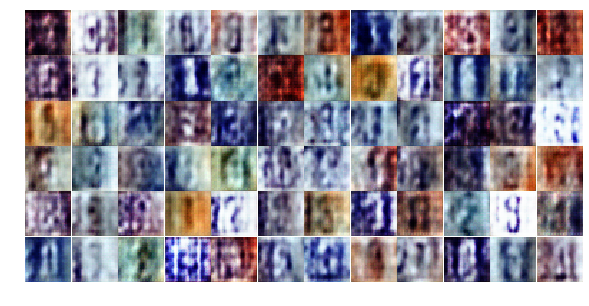

[2/25][10/573] Loss_D: 1.2448 Loss_G: 1.3276 D(x): 0.4375 D(G(z)): 0.2693 / 0.3065
[2/25][20/573] Loss_D: 1.0108 Loss_G: 2.5632 D(x): 0.8305 D(G(z)): 0.5259 / 0.0984
[2/25][30/573] Loss_D: 1.1650 Loss_G: 1.4476 D(x): 0.5552 D(G(z)): 0.3922 / 0.2588
[2/25][40/573] Loss_D: 1.3334 Loss_G: 1.3190 D(x): 0.4084 D(G(z)): 0.2138 / 0.3053
[2/25][50/573] Loss_D: 0.9671 Loss_G: 1.5242 D(x): 0.6412 D(G(z)): 0.3716 / 0.2445
[2/25][60/573] Loss_D: 1.2892 Loss_G: 1.3960 D(x): 0.6185 D(G(z)): 0.4891 / 0.2958
[2/25][70/573] Loss_D: 1.1982 Loss_G: 1.4830 D(x): 0.6171 D(G(z)): 0.4554 / 0.2593
[2/25][80/573] Loss_D: 1.2858 Loss_G: 1.3438 D(x): 0.3715 D(G(z)): 0.1431 / 0.2941
[2/25][90/573] Loss_D: 0.9504 Loss_G: 1.4044 D(x): 0.6531 D(G(z)): 0.3731 / 0.2714
[2/25][100/573] Loss_D: 1.1677 Loss_G: 1.4885 D(x): 0.6020 D(G(z)): 0.4358 / 0.2553
[2/25][110/573] Loss_D: 1.1970 Loss_G: 1.0386 D(x): 0.4434 D(G(z)): 0.2444 / 0.3801
[2/25][120/573] Loss_D: 1.0982 Loss_G: 1.3242 D(x): 0.6042 D(G(z)): 0.4012 / 0.2923
[

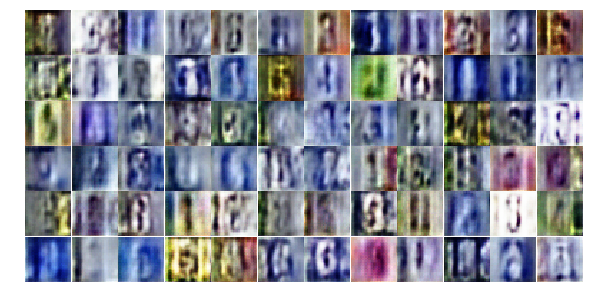

[3/25][10/573] Loss_D: 0.6693 Loss_G: 1.5807 D(x): 0.6847 D(G(z)): 0.2208 / 0.2373
[3/25][20/573] Loss_D: 0.6206 Loss_G: 1.7400 D(x): 0.6856 D(G(z)): 0.1798 / 0.2143
[3/25][30/573] Loss_D: 0.7321 Loss_G: 1.6783 D(x): 0.6827 D(G(z)): 0.2564 / 0.2149
[3/25][40/573] Loss_D: 0.5956 Loss_G: 2.5483 D(x): 0.7985 D(G(z)): 0.2868 / 0.0927
[3/25][50/573] Loss_D: 2.4233 Loss_G: 3.4679 D(x): 0.8984 D(G(z)): 0.8647 / 0.0481
[3/25][60/573] Loss_D: 1.2260 Loss_G: 2.3691 D(x): 0.6478 D(G(z)): 0.4935 / 0.1366
[3/25][70/573] Loss_D: 0.6639 Loss_G: 2.4380 D(x): 0.8634 D(G(z)): 0.3719 / 0.1152
[3/25][80/573] Loss_D: 0.8331 Loss_G: 1.8624 D(x): 0.7361 D(G(z)): 0.3824 / 0.1844
[3/25][90/573] Loss_D: 0.8992 Loss_G: 1.4885 D(x): 0.5590 D(G(z)): 0.1803 / 0.2638
[3/25][100/573] Loss_D: 0.8438 Loss_G: 1.7299 D(x): 0.5336 D(G(z)): 0.1182 / 0.2180
[3/25][110/573] Loss_D: 0.5559 Loss_G: 2.2145 D(x): 0.7984 D(G(z)): 0.2561 / 0.1393
[3/25][120/573] Loss_D: 0.6248 Loss_G: 1.9757 D(x): 0.6928 D(G(z)): 0.1962 / 0.1754
[

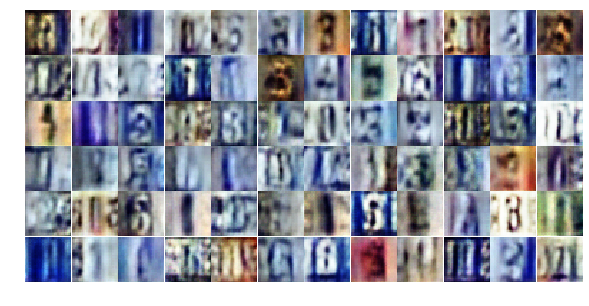

[4/25][10/573] Loss_D: 0.4916 Loss_G: 2.0317 D(x): 0.8037 D(G(z)): 0.2190 / 0.1607
[4/25][20/573] Loss_D: 0.5327 Loss_G: 1.7264 D(x): 0.7055 D(G(z)): 0.1318 / 0.2172
[4/25][30/573] Loss_D: 0.5123 Loss_G: 1.8157 D(x): 0.6814 D(G(z)): 0.0958 / 0.2033
[4/25][40/573] Loss_D: 0.5314 Loss_G: 2.2454 D(x): 0.7442 D(G(z)): 0.1673 / 0.1479
[4/25][50/573] Loss_D: 0.4505 Loss_G: 1.8704 D(x): 0.7775 D(G(z)): 0.1588 / 0.1849
[4/25][60/573] Loss_D: 0.6696 Loss_G: 2.4566 D(x): 0.8722 D(G(z)): 0.3690 / 0.1092
[4/25][70/573] Loss_D: 0.5493 Loss_G: 1.8387 D(x): 0.6880 D(G(z)): 0.1219 / 0.2065
[4/25][80/573] Loss_D: 1.2761 Loss_G: 1.6064 D(x): 0.4467 D(G(z)): 0.1078 / 0.2603
[4/25][90/573] Loss_D: 0.5084 Loss_G: 1.9118 D(x): 0.7474 D(G(z)): 0.1682 / 0.2012
[4/25][100/573] Loss_D: 0.5710 Loss_G: 2.8776 D(x): 0.8576 D(G(z)): 0.3105 / 0.0750
[4/25][110/573] Loss_D: 0.6032 Loss_G: 2.8651 D(x): 0.8877 D(G(z)): 0.3587 / 0.0783
[4/25][120/573] Loss_D: 0.4597 Loss_G: 2.0612 D(x): 0.7684 D(G(z)): 0.1598 / 0.1491
[

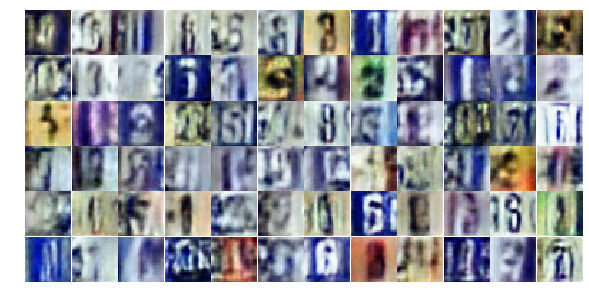

[5/25][10/573] Loss_D: 0.7034 Loss_G: 1.6544 D(x): 0.5995 D(G(z)): 0.1284 / 0.2552
[5/25][20/573] Loss_D: 0.6154 Loss_G: 1.8273 D(x): 0.7162 D(G(z)): 0.2201 / 0.1913
[5/25][30/573] Loss_D: 0.6356 Loss_G: 1.4053 D(x): 0.6493 D(G(z)): 0.1530 / 0.2947
[5/25][40/573] Loss_D: 0.4685 Loss_G: 2.0555 D(x): 0.8126 D(G(z)): 0.2093 / 0.1588
[5/25][50/573] Loss_D: 0.6128 Loss_G: 2.0858 D(x): 0.7884 D(G(z)): 0.2893 / 0.1512
[5/25][60/573] Loss_D: 0.5074 Loss_G: 1.4635 D(x): 0.7078 D(G(z)): 0.1216 / 0.2707
[5/25][70/573] Loss_D: 0.5035 Loss_G: 2.1814 D(x): 0.7707 D(G(z)): 0.1884 / 0.1444
[5/25][80/573] Loss_D: 0.5457 Loss_G: 2.5547 D(x): 0.8549 D(G(z)): 0.2993 / 0.0994
[5/25][90/573] Loss_D: 0.7467 Loss_G: 1.1549 D(x): 0.5365 D(G(z)): 0.0581 / 0.3705
[5/25][100/573] Loss_D: 0.6982 Loss_G: 1.3786 D(x): 0.6011 D(G(z)): 0.1157 / 0.2897
[5/25][110/573] Loss_D: 0.6123 Loss_G: 0.7964 D(x): 0.6369 D(G(z)): 0.1111 / 0.4938
[5/25][120/573] Loss_D: 0.5822 Loss_G: 1.7570 D(x): 0.6347 D(G(z)): 0.0803 / 0.2249
[

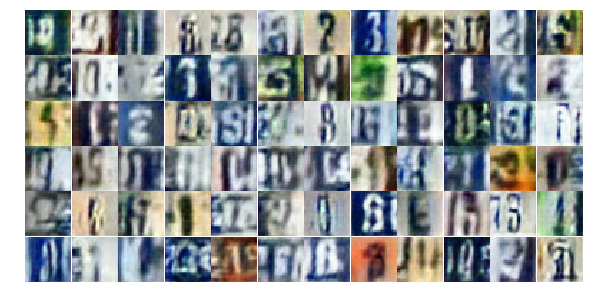

[6/25][10/573] Loss_D: 1.3270 Loss_G: 4.2074 D(x): 0.9042 D(G(z)): 0.6557 / 0.0247
[6/25][20/573] Loss_D: 0.9092 Loss_G: 1.4984 D(x): 0.4722 D(G(z)): 0.0694 / 0.2726
[6/25][30/573] Loss_D: 0.6445 Loss_G: 2.1917 D(x): 0.8468 D(G(z)): 0.3575 / 0.1352
[6/25][40/573] Loss_D: 0.8037 Loss_G: 1.6206 D(x): 0.6513 D(G(z)): 0.2777 / 0.2259
[6/25][50/573] Loss_D: 0.5724 Loss_G: 2.1168 D(x): 0.7955 D(G(z)): 0.2750 / 0.1384
[6/25][60/573] Loss_D: 0.7341 Loss_G: 2.9379 D(x): 0.8500 D(G(z)): 0.4024 / 0.0708
[6/25][70/573] Loss_D: 0.8869 Loss_G: 1.5491 D(x): 0.4956 D(G(z)): 0.0894 / 0.2591
[6/25][80/573] Loss_D: 0.5712 Loss_G: 1.9494 D(x): 0.7548 D(G(z)): 0.2181 / 0.1803
[6/25][90/573] Loss_D: 0.7388 Loss_G: 1.5437 D(x): 0.5665 D(G(z)): 0.1007 / 0.2486
[6/25][100/573] Loss_D: 0.5456 Loss_G: 2.5810 D(x): 0.8329 D(G(z)): 0.2836 / 0.0917
[6/25][110/573] Loss_D: 1.1992 Loss_G: 3.2048 D(x): 0.9130 D(G(z)): 0.6396 / 0.0534
[6/25][120/573] Loss_D: 0.7023 Loss_G: 1.4535 D(x): 0.7407 D(G(z)): 0.2996 / 0.2809
[

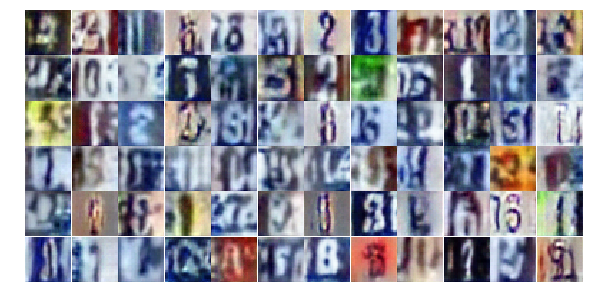

[7/25][10/573] Loss_D: 0.6843 Loss_G: 1.6151 D(x): 0.6100 D(G(z)): 0.1343 / 0.2517
[7/25][20/573] Loss_D: 0.6169 Loss_G: 1.6066 D(x): 0.6792 D(G(z)): 0.1756 / 0.2353
[7/25][30/573] Loss_D: 0.4231 Loss_G: 2.4100 D(x): 0.9302 D(G(z)): 0.2807 / 0.1088
[7/25][40/573] Loss_D: 0.4980 Loss_G: 2.3644 D(x): 0.8179 D(G(z)): 0.2364 / 0.1208
[7/25][50/573] Loss_D: 0.6154 Loss_G: 3.1087 D(x): 0.9472 D(G(z)): 0.4030 / 0.0546
[7/25][60/573] Loss_D: 0.5170 Loss_G: 1.9045 D(x): 0.7669 D(G(z)): 0.2029 / 0.1916
[7/25][70/573] Loss_D: 0.3857 Loss_G: 1.7616 D(x): 0.8343 D(G(z)): 0.1733 / 0.1960
[7/25][80/573] Loss_D: 0.5608 Loss_G: 1.8867 D(x): 0.7638 D(G(z)): 0.2334 / 0.1812
[7/25][90/573] Loss_D: 0.4488 Loss_G: 2.0438 D(x): 0.7855 D(G(z)): 0.1730 / 0.1514
[7/25][100/573] Loss_D: 0.4114 Loss_G: 1.8828 D(x): 0.8671 D(G(z)): 0.2197 / 0.1858
[7/25][110/573] Loss_D: 0.5224 Loss_G: 2.9190 D(x): 0.8412 D(G(z)): 0.2789 / 0.0671
[7/25][120/573] Loss_D: 1.6037 Loss_G: 4.2107 D(x): 0.9130 D(G(z)): 0.7275 / 0.0262
[

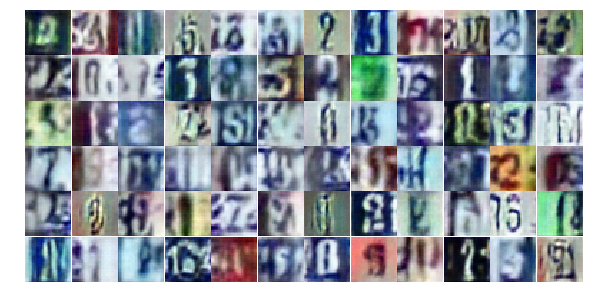

[8/25][10/573] Loss_D: 0.4936 Loss_G: 2.0850 D(x): 0.7639 D(G(z)): 0.1793 / 0.1603
[8/25][20/573] Loss_D: 0.6062 Loss_G: 1.4084 D(x): 0.6443 D(G(z)): 0.1170 / 0.2819
[8/25][30/573] Loss_D: 0.9710 Loss_G: 2.8270 D(x): 0.8364 D(G(z)): 0.5011 / 0.0776
[8/25][40/573] Loss_D: 2.4723 Loss_G: 0.0580 D(x): 0.1190 D(G(z)): 0.0343 / 0.9453
[8/25][50/573] Loss_D: 1.1911 Loss_G: 1.4237 D(x): 0.3881 D(G(z)): 0.0606 / 0.3291
[8/25][60/573] Loss_D: 0.7118 Loss_G: 1.9835 D(x): 0.7870 D(G(z)): 0.3280 / 0.1742
[8/25][70/573] Loss_D: 0.8525 Loss_G: 1.0051 D(x): 0.5421 D(G(z)): 0.1456 / 0.4050
[8/25][80/573] Loss_D: 0.6729 Loss_G: 2.5901 D(x): 0.8358 D(G(z)): 0.3595 / 0.0972
[8/25][90/573] Loss_D: 0.5099 Loss_G: 1.6889 D(x): 0.7755 D(G(z)): 0.2014 / 0.2120
[8/25][100/573] Loss_D: 0.6406 Loss_G: 1.5922 D(x): 0.6135 D(G(z)): 0.0928 / 0.2556
[8/25][110/573] Loss_D: 0.5899 Loss_G: 1.8916 D(x): 0.7091 D(G(z)): 0.1924 / 0.1789
[8/25][120/573] Loss_D: 0.4315 Loss_G: 2.4476 D(x): 0.7428 D(G(z)): 0.1013 / 0.1161
[

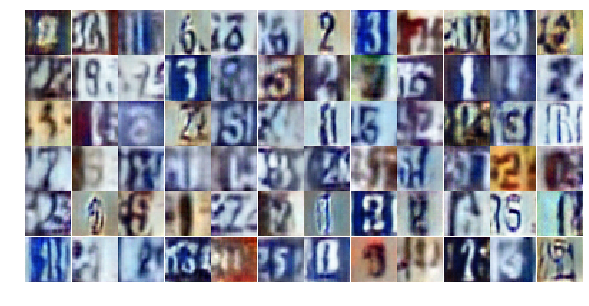

[9/25][10/573] Loss_D: 0.4797 Loss_G: 2.3677 D(x): 0.7348 D(G(z)): 0.1358 / 0.1239
[9/25][20/573] Loss_D: 0.6442 Loss_G: 2.0236 D(x): 0.7123 D(G(z)): 0.2281 / 0.1686
[9/25][30/573] Loss_D: 0.5210 Loss_G: 1.9492 D(x): 0.7434 D(G(z)): 0.1769 / 0.1918
[9/25][40/573] Loss_D: 0.5003 Loss_G: 2.0535 D(x): 0.8159 D(G(z)): 0.2273 / 0.1590
[9/25][50/573] Loss_D: 0.8879 Loss_G: 4.3458 D(x): 0.8601 D(G(z)): 0.4838 / 0.0246
[9/25][60/573] Loss_D: 0.6019 Loss_G: 1.8493 D(x): 0.8369 D(G(z)): 0.3228 / 0.1985
[9/25][70/573] Loss_D: 0.4446 Loss_G: 2.5396 D(x): 0.8019 D(G(z)): 0.1793 / 0.0997
[9/25][80/573] Loss_D: 0.4716 Loss_G: 2.4562 D(x): 0.7596 D(G(z)): 0.1547 / 0.1221
[9/25][90/573] Loss_D: 0.9030 Loss_G: 2.1514 D(x): 0.7196 D(G(z)): 0.3896 / 0.1643
[9/25][100/573] Loss_D: 0.3729 Loss_G: 2.5636 D(x): 0.8905 D(G(z)): 0.2134 / 0.1034
[9/25][110/573] Loss_D: 0.4701 Loss_G: 2.2037 D(x): 0.7432 D(G(z)): 0.1333 / 0.1383
[9/25][120/573] Loss_D: 0.5926 Loss_G: 1.8972 D(x): 0.7362 D(G(z)): 0.2254 / 0.1858
[

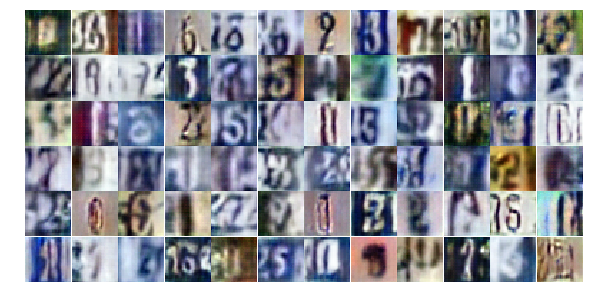

[10/25][10/573] Loss_D: 0.5869 Loss_G: 2.3306 D(x): 0.8376 D(G(z)): 0.3072 / 0.1332
[10/25][20/573] Loss_D: 0.6402 Loss_G: 2.3634 D(x): 0.9027 D(G(z)): 0.3484 / 0.1407
[10/25][30/573] Loss_D: 0.2952 Loss_G: 2.7648 D(x): 0.8956 D(G(z)): 0.1606 / 0.0797
[10/25][40/573] Loss_D: 0.4940 Loss_G: 2.0675 D(x): 0.8473 D(G(z)): 0.2614 / 0.1483
[10/25][50/573] Loss_D: 0.5797 Loss_G: 2.4151 D(x): 0.6282 D(G(z)): 0.0707 / 0.1300
[10/25][60/573] Loss_D: 0.4636 Loss_G: 2.0237 D(x): 0.7676 D(G(z)): 0.1626 / 0.1633
[10/25][70/573] Loss_D: 0.3312 Loss_G: 2.2528 D(x): 0.8328 D(G(z)): 0.1252 / 0.1336
[10/25][80/573] Loss_D: 0.7314 Loss_G: 2.7215 D(x): 0.8814 D(G(z)): 0.4248 / 0.0922
[10/25][90/573] Loss_D: 0.6423 Loss_G: 1.5528 D(x): 0.6257 D(G(z)): 0.1192 / 0.2715
[10/25][100/573] Loss_D: 0.6934 Loss_G: 2.9901 D(x): 0.8560 D(G(z)): 0.3817 / 0.0709
[10/25][110/573] Loss_D: 0.3639 Loss_G: 2.4147 D(x): 0.8404 D(G(z)): 0.1622 / 0.1072
[10/25][120/573] Loss_D: 0.6349 Loss_G: 2.4788 D(x): 0.8452 D(G(z)): 0.344

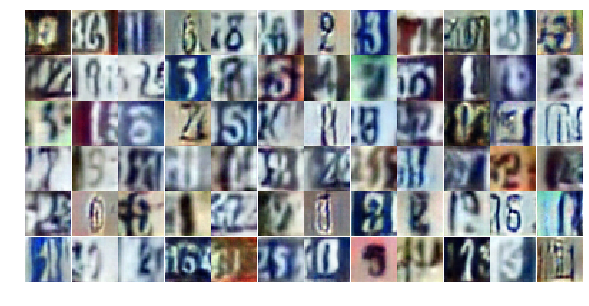

[11/25][10/573] Loss_D: 0.3993 Loss_G: 2.0508 D(x): 0.8000 D(G(z)): 0.1462 / 0.1585
[11/25][20/573] Loss_D: 0.5475 Loss_G: 2.9444 D(x): 0.9159 D(G(z)): 0.3440 / 0.0680
[11/25][30/573] Loss_D: 0.4255 Loss_G: 1.9962 D(x): 0.7940 D(G(z)): 0.1616 / 0.1637
[11/25][40/573] Loss_D: 0.6899 Loss_G: 1.2029 D(x): 0.6203 D(G(z)): 0.1418 / 0.3533
[11/25][50/573] Loss_D: 1.0512 Loss_G: 1.7674 D(x): 0.5785 D(G(z)): 0.3091 / 0.2328
[11/25][60/573] Loss_D: 1.1647 Loss_G: 1.3585 D(x): 0.4367 D(G(z)): 0.1402 / 0.3121
[11/25][70/573] Loss_D: 0.8947 Loss_G: 1.9058 D(x): 0.6476 D(G(z)): 0.3097 / 0.1866
[11/25][80/573] Loss_D: 0.5359 Loss_G: 1.9958 D(x): 0.8415 D(G(z)): 0.2806 / 0.1634
[11/25][90/573] Loss_D: 0.3523 Loss_G: 2.2976 D(x): 0.8361 D(G(z)): 0.1437 / 0.1374
[11/25][100/573] Loss_D: 0.5022 Loss_G: 2.1662 D(x): 0.8580 D(G(z)): 0.2724 / 0.1443
[11/25][110/573] Loss_D: 0.6881 Loss_G: 2.5808 D(x): 0.9151 D(G(z)): 0.4191 / 0.0991
[11/25][120/573] Loss_D: 0.8618 Loss_G: 1.0152 D(x): 0.4889 D(G(z)): 0.064

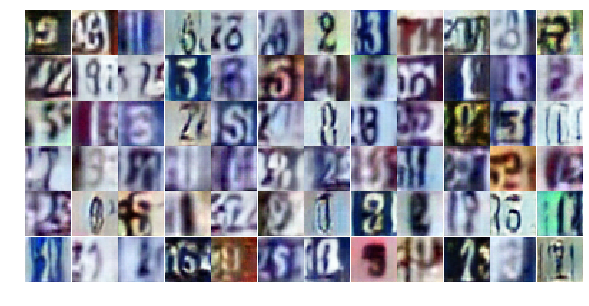

[12/25][10/573] Loss_D: 0.5500 Loss_G: 3.4423 D(x): 0.8604 D(G(z)): 0.2872 / 0.0459
[12/25][20/573] Loss_D: 0.4568 Loss_G: 2.5499 D(x): 0.9030 D(G(z)): 0.2754 / 0.1009
[12/25][30/573] Loss_D: 0.5291 Loss_G: 2.4549 D(x): 0.6829 D(G(z)): 0.0931 / 0.1262
[12/25][40/573] Loss_D: 0.8187 Loss_G: 2.3549 D(x): 0.6958 D(G(z)): 0.3064 / 0.1389
[12/25][50/573] Loss_D: 0.4281 Loss_G: 2.5387 D(x): 0.8785 D(G(z)): 0.2388 / 0.1122
[12/25][60/573] Loss_D: 1.4866 Loss_G: 0.3966 D(x): 0.2999 D(G(z)): 0.0377 / 0.7087
[12/25][70/573] Loss_D: 1.2313 Loss_G: 3.5743 D(x): 0.9070 D(G(z)): 0.6167 / 0.0415
[12/25][80/573] Loss_D: 0.3186 Loss_G: 2.9691 D(x): 0.8777 D(G(z)): 0.1537 / 0.0729
[12/25][90/573] Loss_D: 0.8003 Loss_G: 1.0218 D(x): 0.5943 D(G(z)): 0.1906 / 0.4091
[12/25][100/573] Loss_D: 0.4954 Loss_G: 2.0393 D(x): 0.7448 D(G(z)): 0.1557 / 0.1716
[12/25][110/573] Loss_D: 0.6666 Loss_G: 3.3377 D(x): 0.9323 D(G(z)): 0.4176 / 0.0463
[12/25][120/573] Loss_D: 0.4348 Loss_G: 2.6272 D(x): 0.8523 D(G(z)): 0.212

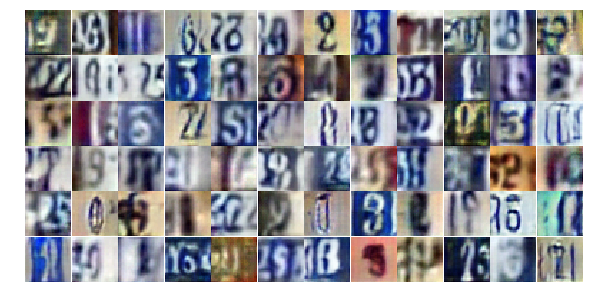

[13/25][10/573] Loss_D: 1.1140 Loss_G: 0.2857 D(x): 0.4031 D(G(z)): 0.0545 / 0.7744
[13/25][20/573] Loss_D: 2.2151 Loss_G: 0.4389 D(x): 0.2257 D(G(z)): 0.1957 / 0.6754
[13/25][30/573] Loss_D: 1.5775 Loss_G: 1.3507 D(x): 0.5414 D(G(z)): 0.4006 / 0.3879
[13/25][40/573] Loss_D: 0.7439 Loss_G: 3.0815 D(x): 0.8443 D(G(z)): 0.3854 / 0.0745
[13/25][50/573] Loss_D: 0.8978 Loss_G: 3.4096 D(x): 0.8152 D(G(z)): 0.4302 / 0.0518
[13/25][60/573] Loss_D: 0.7091 Loss_G: 1.4680 D(x): 0.6174 D(G(z)): 0.1587 / 0.3174
[13/25][70/573] Loss_D: 0.9655 Loss_G: 2.2884 D(x): 0.9128 D(G(z)): 0.5401 / 0.1308
[13/25][80/573] Loss_D: 0.4014 Loss_G: 2.3919 D(x): 0.8387 D(G(z)): 0.1861 / 0.1233
[13/25][90/573] Loss_D: 0.6045 Loss_G: 1.6641 D(x): 0.6793 D(G(z)): 0.1623 / 0.2418
[13/25][100/573] Loss_D: 0.5824 Loss_G: 1.9917 D(x): 0.7001 D(G(z)): 0.1689 / 0.1853
[13/25][110/573] Loss_D: 0.4790 Loss_G: 2.2330 D(x): 0.7746 D(G(z)): 0.1791 / 0.1293
[13/25][120/573] Loss_D: 0.4314 Loss_G: 2.3172 D(x): 0.8328 D(G(z)): 0.203

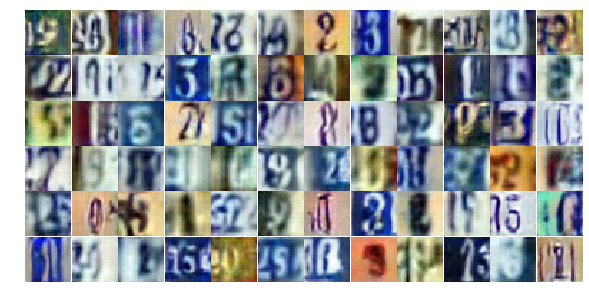

[14/25][10/573] Loss_D: 0.5648 Loss_G: 2.1884 D(x): 0.7916 D(G(z)): 0.2565 / 0.1403
[14/25][20/573] Loss_D: 0.4089 Loss_G: 2.5834 D(x): 0.7441 D(G(z)): 0.0845 / 0.1060
[14/25][30/573] Loss_D: 0.6742 Loss_G: 2.2754 D(x): 0.8494 D(G(z)): 0.3698 / 0.1329
[14/25][40/573] Loss_D: 0.5563 Loss_G: 1.7320 D(x): 0.7333 D(G(z)): 0.1885 / 0.2352
[14/25][50/573] Loss_D: 0.3840 Loss_G: 3.5393 D(x): 0.9585 D(G(z)): 0.2674 / 0.0419
[14/25][60/573] Loss_D: 0.6314 Loss_G: 1.6050 D(x): 0.6211 D(G(z)): 0.1034 / 0.2766
[14/25][70/573] Loss_D: 0.4852 Loss_G: 2.4698 D(x): 0.8566 D(G(z)): 0.2606 / 0.1031
[14/25][80/573] Loss_D: 0.3946 Loss_G: 1.7884 D(x): 0.7811 D(G(z)): 0.1196 / 0.2053
[14/25][90/573] Loss_D: 0.3552 Loss_G: 2.3653 D(x): 0.7601 D(G(z)): 0.0624 / 0.1252
[14/25][100/573] Loss_D: 0.5198 Loss_G: 3.3363 D(x): 0.9396 D(G(z)): 0.3358 / 0.0518
[14/25][110/573] Loss_D: 0.3448 Loss_G: 3.1151 D(x): 0.8681 D(G(z)): 0.1735 / 0.0568
[14/25][120/573] Loss_D: 0.3106 Loss_G: 3.2703 D(x): 0.9392 D(G(z)): 0.206

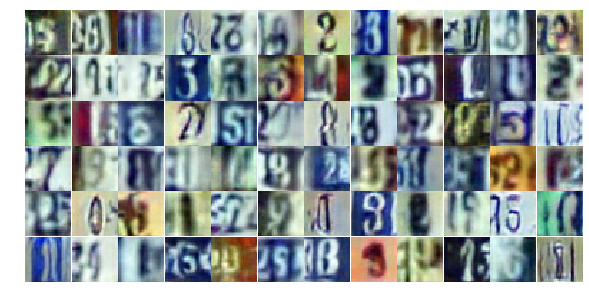

[15/25][10/573] Loss_D: 0.3547 Loss_G: 2.6089 D(x): 0.8905 D(G(z)): 0.2016 / 0.0922
[15/25][20/573] Loss_D: 0.3373 Loss_G: 2.3532 D(x): 0.8688 D(G(z)): 0.1666 / 0.1228
[15/25][30/573] Loss_D: 0.3143 Loss_G: 2.7035 D(x): 0.8455 D(G(z)): 0.1242 / 0.0926
[15/25][40/573] Loss_D: 0.8759 Loss_G: 1.0678 D(x): 0.5054 D(G(z)): 0.0885 / 0.3953
[15/25][50/573] Loss_D: 0.7212 Loss_G: 1.9613 D(x): 0.6546 D(G(z)): 0.1943 / 0.2062
[15/25][60/573] Loss_D: 0.7091 Loss_G: 2.0015 D(x): 0.8154 D(G(z)): 0.3591 / 0.1598
[15/25][70/573] Loss_D: 0.3372 Loss_G: 3.1381 D(x): 0.8781 D(G(z)): 0.1685 / 0.0592
[15/25][80/573] Loss_D: 0.9749 Loss_G: 3.0073 D(x): 0.9498 D(G(z)): 0.5728 / 0.0644
[15/25][90/573] Loss_D: 0.6286 Loss_G: 2.3788 D(x): 0.8047 D(G(z)): 0.3079 / 0.1121
[15/25][100/573] Loss_D: 0.4128 Loss_G: 2.6829 D(x): 0.8982 D(G(z)): 0.2482 / 0.0933
[15/25][110/573] Loss_D: 0.3601 Loss_G: 2.5017 D(x): 0.9195 D(G(z)): 0.2201 / 0.1144
[15/25][120/573] Loss_D: 0.5117 Loss_G: 1.8513 D(x): 0.7242 D(G(z)): 0.131

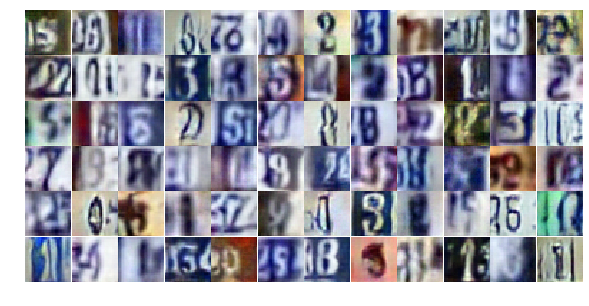

[16/25][10/573] Loss_D: 0.7064 Loss_G: 1.5951 D(x): 0.5678 D(G(z)): 0.0687 / 0.2624
[16/25][20/573] Loss_D: 1.0832 Loss_G: 2.9566 D(x): 0.8963 D(G(z)): 0.5646 / 0.0799
[16/25][30/573] Loss_D: 0.4584 Loss_G: 1.7541 D(x): 0.8317 D(G(z)): 0.1887 / 0.2147
[16/25][40/573] Loss_D: 0.5163 Loss_G: 2.1605 D(x): 0.6870 D(G(z)): 0.0893 / 0.1531
[16/25][50/573] Loss_D: 0.2858 Loss_G: 3.0183 D(x): 0.8650 D(G(z)): 0.1213 / 0.0642
[16/25][60/573] Loss_D: 0.6105 Loss_G: 3.1688 D(x): 0.8331 D(G(z)): 0.3101 / 0.0614
[16/25][70/573] Loss_D: 0.5389 Loss_G: 3.1056 D(x): 0.8687 D(G(z)): 0.3023 / 0.0585
[16/25][80/573] Loss_D: 0.3476 Loss_G: 2.3015 D(x): 0.7944 D(G(z)): 0.0970 / 0.1375
[16/25][90/573] Loss_D: 0.4402 Loss_G: 2.4702 D(x): 0.7560 D(G(z)): 0.1227 / 0.1239
[16/25][100/573] Loss_D: 0.6606 Loss_G: 1.1134 D(x): 0.6876 D(G(z)): 0.1934 / 0.3878
[16/25][110/573] Loss_D: 0.5378 Loss_G: 1.3753 D(x): 0.7403 D(G(z)): 0.1727 / 0.3281
[16/25][120/573] Loss_D: 0.3868 Loss_G: 2.6723 D(x): 0.8654 D(G(z)): 0.197

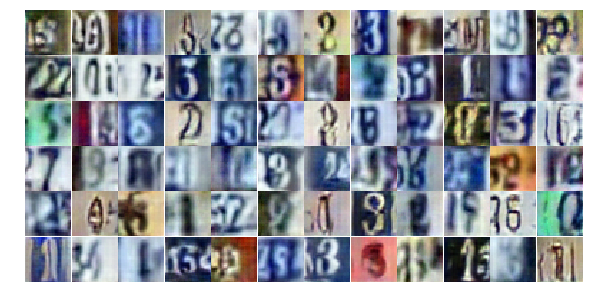

[17/25][10/573] Loss_D: 0.4159 Loss_G: 2.7784 D(x): 0.9299 D(G(z)): 0.2680 / 0.0788
[17/25][20/573] Loss_D: 0.4615 Loss_G: 2.3520 D(x): 0.7770 D(G(z)): 0.1674 / 0.1311
[17/25][30/573] Loss_D: 0.4185 Loss_G: 2.6919 D(x): 0.8368 D(G(z)): 0.1856 / 0.1027
[17/25][40/573] Loss_D: 0.2728 Loss_G: 2.7967 D(x): 0.8370 D(G(z)): 0.0801 / 0.0773
[17/25][50/573] Loss_D: 0.5449 Loss_G: 2.8450 D(x): 0.8189 D(G(z)): 0.2597 / 0.0785
[17/25][60/573] Loss_D: 0.5384 Loss_G: 2.3787 D(x): 0.8482 D(G(z)): 0.2828 / 0.1250
[17/25][70/573] Loss_D: 0.5574 Loss_G: 2.4649 D(x): 0.8082 D(G(z)): 0.2478 / 0.1195
[17/25][80/573] Loss_D: 0.5939 Loss_G: 2.2041 D(x): 0.8782 D(G(z)): 0.3356 / 0.1452
[17/25][90/573] Loss_D: 0.4873 Loss_G: 2.4299 D(x): 0.7307 D(G(z)): 0.1286 / 0.1297
[17/25][100/573] Loss_D: 0.4629 Loss_G: 2.2519 D(x): 0.8548 D(G(z)): 0.2398 / 0.1457
[17/25][110/573] Loss_D: 0.3422 Loss_G: 3.3875 D(x): 0.8914 D(G(z)): 0.1862 / 0.0500
[17/25][120/573] Loss_D: 0.3871 Loss_G: 3.3153 D(x): 0.9277 D(G(z)): 0.251

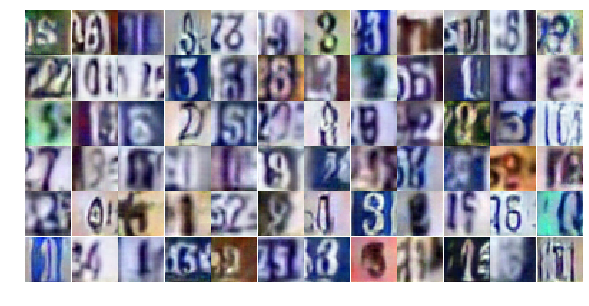

[18/25][10/573] Loss_D: 0.3729 Loss_G: 2.5993 D(x): 0.8916 D(G(z)): 0.2121 / 0.1022
[18/25][20/573] Loss_D: 0.2972 Loss_G: 3.6332 D(x): 0.9065 D(G(z)): 0.1628 / 0.0365
[18/25][30/573] Loss_D: 0.3853 Loss_G: 2.4636 D(x): 0.7633 D(G(z)): 0.0824 / 0.1132
[18/25][40/573] Loss_D: 0.5677 Loss_G: 2.1712 D(x): 0.7797 D(G(z)): 0.2363 / 0.1530
[18/25][50/573] Loss_D: 0.3505 Loss_G: 2.8102 D(x): 0.8802 D(G(z)): 0.1849 / 0.0806
[18/25][60/573] Loss_D: 0.6871 Loss_G: 2.0209 D(x): 0.5612 D(G(z)): 0.0361 / 0.1965
[18/25][70/573] Loss_D: 0.4361 Loss_G: 2.3893 D(x): 0.8437 D(G(z)): 0.2101 / 0.1255
[18/25][80/573] Loss_D: 0.6582 Loss_G: 3.2196 D(x): 0.9603 D(G(z)): 0.4247 / 0.0502
[18/25][90/573] Loss_D: 0.5372 Loss_G: 2.0170 D(x): 0.6537 D(G(z)): 0.0633 / 0.1831
[18/25][100/573] Loss_D: 0.3533 Loss_G: 2.3096 D(x): 0.8411 D(G(z)): 0.1451 / 0.1342
[18/25][110/573] Loss_D: 0.3206 Loss_G: 2.4341 D(x): 0.8428 D(G(z)): 0.1234 / 0.1176
[18/25][120/573] Loss_D: 0.4099 Loss_G: 3.4075 D(x): 0.9626 D(G(z)): 0.290

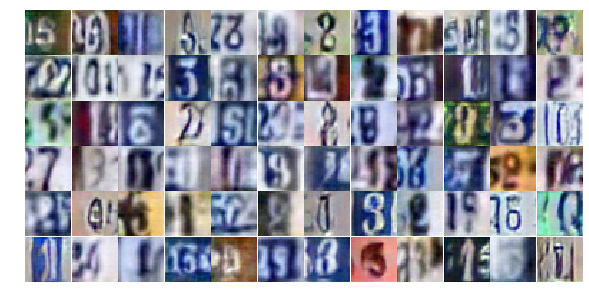

[19/25][10/573] Loss_D: 0.4892 Loss_G: 2.4885 D(x): 0.7328 D(G(z)): 0.1362 / 0.1304
[19/25][20/573] Loss_D: 0.5008 Loss_G: 2.3567 D(x): 0.8614 D(G(z)): 0.2724 / 0.1222
[19/25][30/573] Loss_D: 0.6137 Loss_G: 1.8006 D(x): 0.7432 D(G(z)): 0.2377 / 0.2067
[19/25][40/573] Loss_D: 0.4403 Loss_G: 2.7606 D(x): 0.9358 D(G(z)): 0.2806 / 0.0938
[19/25][50/573] Loss_D: 0.4036 Loss_G: 2.2066 D(x): 0.7816 D(G(z)): 0.1289 / 0.1467
[19/25][60/573] Loss_D: 0.5324 Loss_G: 2.0360 D(x): 0.8266 D(G(z)): 0.2608 / 0.1581
[19/25][70/573] Loss_D: 0.3260 Loss_G: 2.8235 D(x): 0.8893 D(G(z)): 0.1749 / 0.0840
[19/25][80/573] Loss_D: 0.7119 Loss_G: 2.7014 D(x): 0.8051 D(G(z)): 0.3551 / 0.0913
[19/25][90/573] Loss_D: 0.8139 Loss_G: 1.1865 D(x): 0.6139 D(G(z)): 0.2009 / 0.3588
[19/25][100/573] Loss_D: 0.5342 Loss_G: 3.2713 D(x): 0.6434 D(G(z)): 0.0330 / 0.0622
[19/25][110/573] Loss_D: 0.8557 Loss_G: 1.3706 D(x): 0.5346 D(G(z)): 0.1191 / 0.2982
[19/25][120/573] Loss_D: 0.4327 Loss_G: 2.4816 D(x): 0.8612 D(G(z)): 0.224

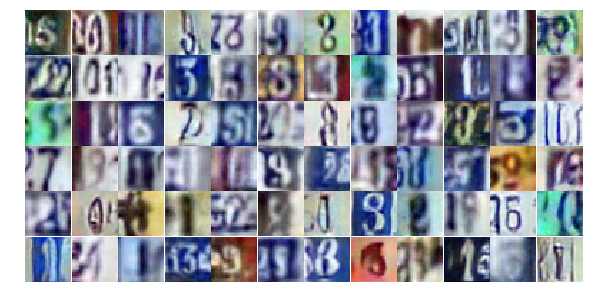

[20/25][10/573] Loss_D: 0.3532 Loss_G: 3.1617 D(x): 0.8299 D(G(z)): 0.1357 / 0.0696
[20/25][20/573] Loss_D: 0.4650 Loss_G: 1.8748 D(x): 0.7024 D(G(z)): 0.0749 / 0.2130
[20/25][30/573] Loss_D: 1.6661 Loss_G: 0.7135 D(x): 0.2502 D(G(z)): 0.0517 / 0.5489
[20/25][40/573] Loss_D: 0.6734 Loss_G: 2.7192 D(x): 0.7999 D(G(z)): 0.3212 / 0.0882
[20/25][50/573] Loss_D: 0.8908 Loss_G: 1.2772 D(x): 0.5224 D(G(z)): 0.1299 / 0.3283
[20/25][60/573] Loss_D: 0.5843 Loss_G: 2.3843 D(x): 0.8788 D(G(z)): 0.3314 / 0.1248
[20/25][70/573] Loss_D: 0.5537 Loss_G: 1.8767 D(x): 0.7722 D(G(z)): 0.2102 / 0.2062
[20/25][80/573] Loss_D: 0.5040 Loss_G: 1.6859 D(x): 0.7610 D(G(z)): 0.1794 / 0.2348
[20/25][90/573] Loss_D: 0.7213 Loss_G: 1.1529 D(x): 0.5795 D(G(z)): 0.0893 / 0.3637
[20/25][100/573] Loss_D: 0.3662 Loss_G: 2.8396 D(x): 0.9213 D(G(z)): 0.2323 / 0.0772
[20/25][110/573] Loss_D: 0.4646 Loss_G: 2.4273 D(x): 0.6938 D(G(z)): 0.0598 / 0.1262
[20/25][120/573] Loss_D: 1.5729 Loss_G: 3.4970 D(x): 0.8731 D(G(z)): 0.692

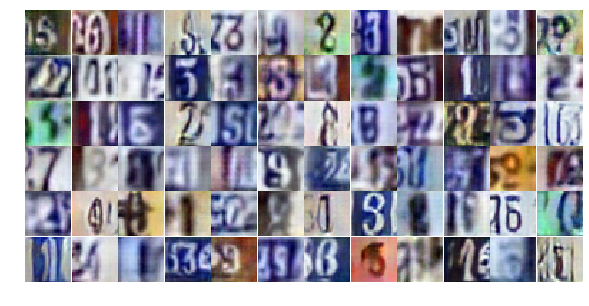

[21/25][10/573] Loss_D: 0.6283 Loss_G: 1.6638 D(x): 0.6932 D(G(z)): 0.1934 / 0.2406
[21/25][20/573] Loss_D: 0.2400 Loss_G: 2.8691 D(x): 0.8743 D(G(z)): 0.0939 / 0.0778
[21/25][30/573] Loss_D: 0.3984 Loss_G: 3.4404 D(x): 0.9687 D(G(z)): 0.2827 / 0.0472
[21/25][40/573] Loss_D: 0.4532 Loss_G: 1.7669 D(x): 0.7800 D(G(z)): 0.1576 / 0.2318
[21/25][50/573] Loss_D: 2.8389 Loss_G: 6.1390 D(x): 0.9782 D(G(z)): 0.8922 / 0.0074
[21/25][60/573] Loss_D: 1.0684 Loss_G: 2.1899 D(x): 0.7799 D(G(z)): 0.4806 / 0.1784
[21/25][70/573] Loss_D: 0.8847 Loss_G: 3.2224 D(x): 0.8379 D(G(z)): 0.4532 / 0.0599
[21/25][80/573] Loss_D: 0.4564 Loss_G: 2.7008 D(x): 0.7464 D(G(z)): 0.1186 / 0.0941
[21/25][90/573] Loss_D: 0.5687 Loss_G: 1.9886 D(x): 0.7510 D(G(z)): 0.2134 / 0.1749
[21/25][100/573] Loss_D: 0.5363 Loss_G: 3.3485 D(x): 0.8772 D(G(z)): 0.3069 / 0.0499
[21/25][110/573] Loss_D: 0.5492 Loss_G: 2.1355 D(x): 0.7113 D(G(z)): 0.1494 / 0.1662
[21/25][120/573] Loss_D: 0.6213 Loss_G: 2.0385 D(x): 0.7915 D(G(z)): 0.286

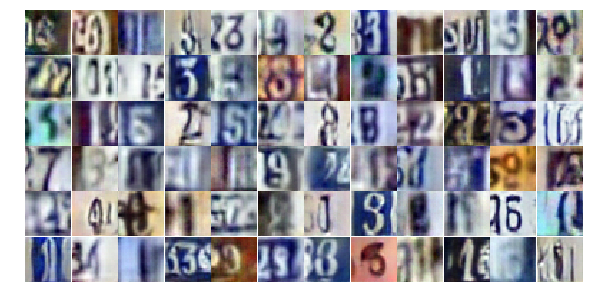

[22/25][10/573] Loss_D: 0.7959 Loss_G: 2.3808 D(x): 0.7918 D(G(z)): 0.3872 / 0.1313
[22/25][20/573] Loss_D: 0.4008 Loss_G: 3.0117 D(x): 0.8723 D(G(z)): 0.2095 / 0.0734
[22/25][30/573] Loss_D: 0.6893 Loss_G: 1.7355 D(x): 0.6284 D(G(z)): 0.1376 / 0.2343
[22/25][40/573] Loss_D: 0.3294 Loss_G: 2.5854 D(x): 0.8112 D(G(z)): 0.1008 / 0.1118
[22/25][50/573] Loss_D: 0.3027 Loss_G: 2.3410 D(x): 0.8501 D(G(z)): 0.1184 / 0.1323
[22/25][60/573] Loss_D: 0.4328 Loss_G: 2.9044 D(x): 0.8195 D(G(z)): 0.1824 / 0.0710
[22/25][70/573] Loss_D: 0.5604 Loss_G: 3.0460 D(x): 0.9546 D(G(z)): 0.3710 / 0.0674
[22/25][80/573] Loss_D: 0.6649 Loss_G: 1.6946 D(x): 0.6124 D(G(z)): 0.1075 / 0.2322
[22/25][90/573] Loss_D: 0.5435 Loss_G: 2.4093 D(x): 0.8963 D(G(z)): 0.3219 / 0.1169
[22/25][100/573] Loss_D: 0.3904 Loss_G: 2.4924 D(x): 0.8493 D(G(z)): 0.1860 / 0.1114
[22/25][110/573] Loss_D: 0.7626 Loss_G: 2.7444 D(x): 0.9197 D(G(z)): 0.4410 / 0.0926
[22/25][120/573] Loss_D: 0.9151 Loss_G: 0.9979 D(x): 0.5943 D(G(z)): 0.223

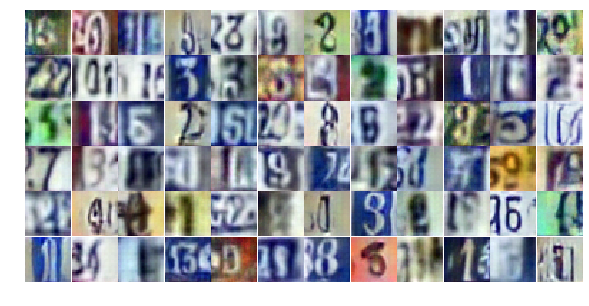

[23/25][10/573] Loss_D: 0.3065 Loss_G: 2.9691 D(x): 0.8495 D(G(z)): 0.1152 / 0.0792
[23/25][20/573] Loss_D: 0.3883 Loss_G: 3.3756 D(x): 0.9364 D(G(z)): 0.2553 / 0.0535
[23/25][30/573] Loss_D: 0.3899 Loss_G: 2.3212 D(x): 0.8251 D(G(z)): 0.1592 / 0.1401
[23/25][40/573] Loss_D: 0.5324 Loss_G: 2.6779 D(x): 0.9051 D(G(z)): 0.3202 / 0.0852
[23/25][50/573] Loss_D: 0.2091 Loss_G: 3.0155 D(x): 0.9032 D(G(z)): 0.0947 / 0.0779
[23/25][60/573] Loss_D: 0.6109 Loss_G: 2.8930 D(x): 0.8492 D(G(z)): 0.3217 / 0.0738
[23/25][70/573] Loss_D: 0.3452 Loss_G: 2.5341 D(x): 0.8668 D(G(z)): 0.1663 / 0.1154
[23/25][80/573] Loss_D: 0.4324 Loss_G: 2.3065 D(x): 0.8359 D(G(z)): 0.1992 / 0.1384
[23/25][90/573] Loss_D: 0.5569 Loss_G: 2.0655 D(x): 0.6420 D(G(z)): 0.0551 / 0.1671
[23/25][100/573] Loss_D: 0.2144 Loss_G: 3.3561 D(x): 0.9779 D(G(z)): 0.1620 / 0.0492
[23/25][110/573] Loss_D: 0.3929 Loss_G: 3.3367 D(x): 0.9364 D(G(z)): 0.2545 / 0.0525
[23/25][120/573] Loss_D: 0.6803 Loss_G: 0.6814 D(x): 0.6221 D(G(z)): 0.121

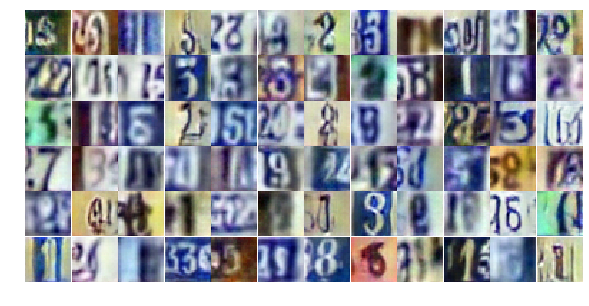

[24/25][10/573] Loss_D: 0.4107 Loss_G: 2.3293 D(x): 0.7402 D(G(z)): 0.0808 / 0.1348
[24/25][20/573] Loss_D: 0.4958 Loss_G: 3.5478 D(x): 0.9106 D(G(z)): 0.3023 / 0.0408
[24/25][30/573] Loss_D: 0.3654 Loss_G: 2.8168 D(x): 0.7423 D(G(z)): 0.0499 / 0.0898
[24/25][40/573] Loss_D: 0.5938 Loss_G: 3.1537 D(x): 0.8790 D(G(z)): 0.3371 / 0.0716
[24/25][50/573] Loss_D: 0.4324 Loss_G: 2.1872 D(x): 0.7376 D(G(z)): 0.0872 / 0.1528
[24/25][60/573] Loss_D: 0.6155 Loss_G: 3.8209 D(x): 0.9371 D(G(z)): 0.3858 / 0.0311
[24/25][70/573] Loss_D: 0.4535 Loss_G: 2.6197 D(x): 0.7800 D(G(z)): 0.1572 / 0.1084
[24/25][80/573] Loss_D: 0.4742 Loss_G: 2.1592 D(x): 0.7348 D(G(z)): 0.1279 / 0.1452
[24/25][90/573] Loss_D: 0.2715 Loss_G: 2.9593 D(x): 0.9276 D(G(z)): 0.1662 / 0.0787
[24/25][100/573] Loss_D: 0.7980 Loss_G: 3.9639 D(x): 0.9448 D(G(z)): 0.4768 / 0.0315
[24/25][110/573] Loss_D: 0.5528 Loss_G: 1.8233 D(x): 0.6409 D(G(z)): 0.0529 / 0.2455
[24/25][120/573] Loss_D: 0.7729 Loss_G: 0.8987 D(x): 0.5894 D(G(z)): 0.153

In [11]:
print_every=10
show_every=1000
samples, losses = [], []

for epoch in range(niter):
  for i, data in enumerate(trainloader, 0):
    if data[0].size()[0] < batchSize:
      continue
    real_data = data[0].to(device)
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # train with real
    d_model.zero_grad()

    output = d_model(real_data)
    label = torch.full((batchSize,), real_label, device=device)

    d_loss_real = criterion(output, label)
    d_loss_real.backward()
    D_x = output.mean().item()

    # train with fake
    noise = torch.randn(batchSize, nz, 1, 1, device=device)
    fake = g_model(noise)
    label.fill_(fake_label)
    output = d_model(fake.detach())
    d_loss_fake = criterion(output, label)
    d_loss_fake.backward()
    D_G_z1 = output.mean().item()
    d_loss = d_loss_real + d_loss_fake
    d_train_optim.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    g_model.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    output = d_model(fake)
    g_loss = criterion(output, label)
    g_loss.backward()
    D_G_z2 = output.mean().item()
    g_train_optim.step()

    if i % print_every == 0:
      print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
            % (epoch, niter, i, len(trainloader),
               d_loss.item(), g_loss.item(), D_x, D_G_z1, D_G_z2))
      losses.append((d_loss.item(), g_loss.item()))
    if i % show_every == 0:
      gen_samples = g_model(sample_noise).detach()
      sample = gen_samples.to(torch.device('cpu')).numpy()
      samples.append(sample)
      _ = view_samples(-1, samples, 6, 12, figsize=(10,5))
      plt.show()

## Sample images after the training

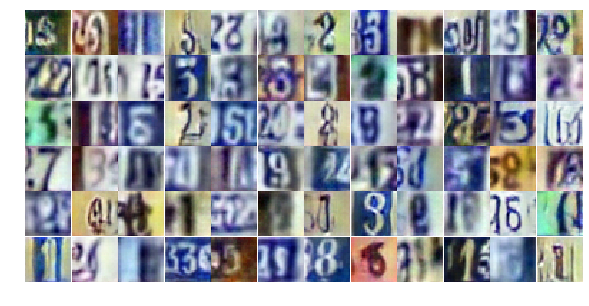

In [12]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

## Training Losses

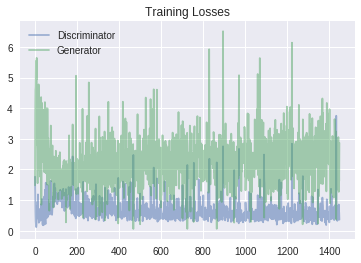

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()